In [45]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
from tqdm import tqdm
from PIL import Image
import argparse
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

In [ ]:
path_mask_RMFD = Path("/Users/karimabdallah/Desktop/Mask-detection/data/data_sets/Facemaskdetection/train/with_mask")
path_nomask_RMFD = Path("/Users/karimabdallah/Desktop/Mask-detection/data/data_sets/Facemaskdetection/train/without_mask")
path_mask_kaggle = Path("/Users/karimabdallah/Desktop/Mask-detection/data/data_sets/kaggle/with_mask")
path_nomask_kaggle = Path("/Users/karimabdallah/Desktop/Mask-detection/data/data_sets/kaggle/without_mask")
path_mask_LWF = Path("/Users/karimabdallah/Desktop/Mask-detection/data/data_sets/lwf/test/with_mask")
path_nomask_LWF = Path("/Users/karimabdallah/Desktop/Mask-detection/data/data_sets/lwf/test/without_mask")
EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

In [3]:
def list_images_rec(root):
    if not root.exists():
        print("MISSING:", root)
        return []
    files = [str(p.resolve()) for p in root.rglob("*") if p.is_file() and p.suffix.lower() in EXTS]
    return files

mask_RMFD_files   = list_images_rec(path_mask_RMFD)
nomask_RMFD_files = list_images_rec(path_nomask_RMFD)
mask_kaggle_files = list_images_rec(path_mask_kaggle)
nomask_kaggle_files = list_images_rec(path_nomask_kaggle)
mask_LWF_files = list_images_rec(path_mask_LWF)
nomask_LWF_files = list_images_rec(path_nomask_LWF)

print("mask count:", len(mask_RMFD_files), " | nomask count:", len(nomask_RMFD_files))
print("mask count:", len(mask_kaggle_files), " | nomask count:", len(nomask_kaggle_files))
print("mask count:", len(mask_LWF_files), " | nomask count:", len(nomask_LWF_files))


mask count: 5857  | nomask count: 5894
mask count: 3725  | nomask count: 3828
mask count: 849  | nomask count: 960


In [4]:
# data set 1: RMFD
DS1_mask_df   = pd.DataFrame({"path": mask_RMFD_files}).assign(label=1, source="DS1")
DS1_nomask_df = pd.DataFrame({"path": nomask_RMFD_files}).assign(label=0, source="DS1")
DS1_df = pd.concat([DS1_nomask_df, DS1_mask_df], ignore_index=True)
DS1_df = DS1_df.drop_duplicates(subset="path", keep="first").reset_index(drop=True)

# data set 2: a kaggle one
DS2_mask_df = pd.DataFrame({'path' : mask_kaggle_files }).assign(label= 1, source= "DS2")
DS2_nomask_df = pd.DataFrame({'path' : nomask_kaggle_files }).assign(label= 0, source= "DS2")
DS2_df = pd.concat([DS2_nomask_df, DS2_mask_df], ignore_index= True)
DS2_df = DS2_df.drop_duplicates(subset= "path", keep= "first").reset_index(drop= True)

# data set 3: LWF
DS4_mask_df = pd.DataFrame({'path' : mask_LWF_files}).assign(label= 1, source= "DS4")
DS4_nomask_df = pd.DataFrame({'path' : nomask_LWF_files}).assign(label= 0, source= "DS4")
DS4_df = pd.concat([DS4_nomask_df, DS4_mask_df], ignore_index= True)
DS4_df = DS4_df.drop_duplicates(subset= "path", keep= "first").reset_index(drop= True)

# splitting into train / val / test
train_val_1, test_1 = train_test_split(DS1_df, test_size= 0.2, shuffle= True, stratify= DS1_df['label'], random_state= 42)
train_1, val_1 = train_test_split(train_val_1, test_size= 0.125, shuffle= True, stratify= train_val_1['label'], random_state= 42)

train_val_2, test_2 = train_test_split(DS2_df, test_size = 0.2, shuffle= True, stratify= DS2_df['label'], random_state= 42)
train_2, val_2 = train_test_split(train_val_2, test_size= 0.125, shuffle= True, stratify= train_val_2['label'], random_state= 42)

# combining into DS3
DS3_train = pd.concat([train_1, train_2], ignore_index= True).drop_duplicates(subset= "path", keep= "first").reset_index(drop= True)
DS3_val = pd.concat([val_1, val_2], ignore_index= True).drop_duplicates(subset= "path", keep= "first").reset_index(drop= True)
DS3_test = pd.concat([test_1, test_2], ignore_index= True).drop_duplicates(subset= "path", keep= "first").reset_index(drop= True)

In [ ]:
DS3_train.to_csv("/Users/karimabdallah/Desktop/Mask-detection/splits/DS3_train.txt",sep="\t", header=False, index=False, columns=["path","label"])
DS3_val.to_csv("/Users/karimabdallah/Desktop/Mask-detection/splits/DS3_val.txt",sep="\t", header=False, index=False, columns=["path","label"])
DS3_test.to_csv("/Users/karimabdallah/Desktop/Mask-detection/splits/DS3_test.txt",sep="\t", header=False, index=False, columns=["path","label"])
DS4_df.to_csv("/Users/karimabdallah/Desktop/Mask-detection/splits/DS4.txt",sep="\t", header=False, index=False, columns=["path","label"])

In [ ]:
path_ds3_train = Path("/Users/karimabdallah/Desktop/Mask-detection/data/splits/DS3_train.txt")
path_ds3_val = Path("/Users/karimabdallah/Desktop/Mask-detection/data/splits/DS3_val.txt")
path_ds3_test = Path("/Users/karimabdallah/Desktop/Mask-detection/data/splits/DS3_test.txt")
path_ds4 = Path("/Users/karimabdallah/Desktop/Mask-detection/data/splits/DS4.txt")

In [7]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
def Transforms(train= False):
  if train:
    return transforms.Compose([
        transforms.RandomResizedCrop(224, scale= (0.8, 1)),
        transforms.RandomHorizontalFlip(p= 0.5),
        transforms.ColorJitter(brightness= 1.1, contrast= 0.9, satruation= 1, hue= 1.02),
        transforms.ToTensor(),
        transforms.Normalize(mean, std,inplace= True)
    ])
  else:
    return transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std, inplace= True)
    ])

In [8]:

def iterate_txt_batches(txt_path, transform, batch_size=64, drop_last=False):
    imgs_buf, labels_buf = [], []

    with open(txt_path, "r", encoding="utf-8") as f:
        for lineno, raw in enumerate(f, start=1):
            line = raw.strip()
            if not line or line.startswith("#"):
                continue
            try:
                path_str, label_str = line.rsplit("\t", 1)  # robust split
            except ValueError:
                raise ValueError(f"[{txt_path}:{lineno}] expected '<path> <label>'")

            img = Image.open(path_str).convert("RGB")
            img = transform(img)  # -> torch.FloatTensor [3,224,224]
            label = int(label_str)

            imgs_buf.append(img)
            labels_buf.append(label)

            if len(imgs_buf) == batch_size:
                yield torch.stack(imgs_buf, dim=0), torch.tensor(labels_buf, dtype=torch.long)
                imgs_buf.clear()
                labels_buf.clear()
                
    if imgs_buf and not drop_last:
        yield torch.stack(imgs_buf, dim=0), torch.tensor(labels_buf, dtype=torch.long)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
resnet = models.resnet50(weights= models.ResNet50_Weights.IMAGENET1K_V2, progress= True)
for p in resnet.parameters():
    p.requires_grad = False
resnet.fc = nn.Identity()
resnet.eval()
resnet.to(device) 
eval_tf = Transforms(train=False)

def npz_file(Paths, transform, batch_size= 64):
    feats_list, labels_list = [], []
    with torch.no_grad():
        for path in Paths:
            for xb, yb in iterate_txt_batches(path, transform, batch_size= 64):
                xb = xb.to(device, non_blocking=True)
                fb = resnet(xb).cpu()
                feats_list.append(fb)
                labels_list.append(yb)
        X = torch.cat(feats_list, dim=0).numpy().astype("float32")
        y = torch.cat(labels_list, dim=0).numpy().astype("int64")
    return  X, y

X_train, y_train = npz_file([path_ds3_train], eval_tf)
X_val, y_val = npz_file([path_ds3_val], eval_tf)
X_test, y_test = npz_file([path_ds3_test], eval_tf)
X_ds4, y_ds4 = npz_file([path_ds4], eval_tf)

np.savez_compressed("/Users/karimabdallah/Desktop/Mask-detection/data/splits/DS3_train.npz", X= X_train, y= y_train)
np.savez_compressed("/Users/karimabdallah/Desktop/Mask-detection/data/splits/DS3_val.npz", X= X_val, y= y_val)
np.savez_compressed("/Users/karimabdallah/Desktop/Mask-detection/data/splits/DS3_test.npz", X= X_test, y= y_test)
np.savez_compressed("/Users/karimabdallah/Desktop/Mask-detection/data/splits/DS4.npz", X= X_ds4, y= y_ds4)

/Users/karimabdallah/miniconda3/envs/torch/lib/python3.10/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
train_data = np.load("/Users/karimabdallah/Desktop/Mask-detection/data/splits/DS3_train.npz", allow_pickle= False)
X_train = train_data["X"]
y_train = train_data["y"]

val_data = np.load("/Users/karimabdallah/Desktop/Mask-detection/data/splits/DS3_val.npz", allow_pickle= False)
X_val = val_data["X"]
y_val = val_data["y"]

test_data = np.load("/Users/karimabdallah/Desktop/Mask-detection/data/splits/DS3_test.npz", allow_pickle= False)
X_test = test_data["X"]
y_test = test_data["y"]

testing_data = np.load("/Users/karimabdallah/Desktop/Mask-detection/data/splits/DS4.npz", allow_pickle= False)
ds4_X_test = testing_data["X"]
ds4_y_test = testing_data["y"]

X_pool = np.concatenate([X_train, X_val]); y_pool = np.concatenate([y_train, y_val])

In [ ]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("SVM", LinearSVC(dual=False, max_iter=10000, random_state=42)),
])
cv = StratifiedKFold(n_splits= 5, shuffle= True, random_state= 42)
params = {
    "SVM__C": [0.1, 1, 5],
    "SVM__class_weight": [None, "balanced"]
}
grid_search = GridSearchCV(
    estimator= pipeline,
    param_grid= params,
    cv= cv,
    scoring= "f1_macro",
    refit= True,
    n_jobs= -1
)

grid_search.fit(X_pool, y_pool)
model = grid_search.best_estimator_
prams = grid_search.best_params_

{'mean_fit_time': array([15.27544322, 15.15295415, 15.22724113, 16.65383759,  6.16122885,
        3.74614677]), 'std_fit_time': array([0.74536373, 0.80707812, 9.98268644, 5.23595837, 0.66150618,
       0.129966  ]), 'mean_score_time': array([0.15866065, 0.14545188, 0.16182203, 0.26834002, 0.23757019,
       0.0437602 ]), 'std_score_time': array([0.03951041, 0.02885817, 0.15022805, 0.11947779, 0.09152668,
       0.01170096]), 'param_SVM__C': masked_array(data=[0.1, 0.1, 1.0, 1.0, 5.0, 5.0],
             mask=[False, False, False, False, False, False],
       fill_value=1e+20), 'param_SVM__class_weight': masked_array(data=[None, 'balanced', None, 'balanced', None, 'balanced'],
             mask=[False, False, False, False, False, False],
       fill_value=np.str_('?'),
            dtype=object), 'params': [{'SVM__C': 0.1, 'SVM__class_weight': None}, {'SVM__C': 0.1, 'SVM__class_weight': 'balanced'}, {'SVM__C': 1, 'SVM__class_weight': None}, {'SVM__C': 1, 'SVM__class_weight': 'balanced'}, 

In [46]:
y_pred = model.predict(X_test)
acc  = accuracy_score(y_test, y_pred)
f1m  = f1_score(y_test, y_pred, average="macro")
prec = precision_score(y_test, y_pred, average="macro")
rec  = recall_score(y_test, y_pred, average="macro")
cm   = confusion_matrix(y_test, y_pred)
print("DS3_test — Acc:", acc, " F1_macro:", f1m, " Prec_macro:", prec, " Rec_macro:", rec)
print("Confusion matrix (DS3_test):\n", cm)
print("\nPer-class report (DS3_test):\n", classification_report(y_test, y_pred, target_names=["no_mask","with_mask"]))

DS3_test — Acc: 0.9966338684619368  F1_macro: 0.9966337274016508  Prec_macro: 0.9966293340199108  Rec_macro: 0.9966393237076463
Confusion matrix (DS3_test):
 [[1937    8]
 [   5 1912]]

Per-class report (DS3_test):
               precision    recall  f1-score   support

     no_mask       1.00      1.00      1.00      1945
   with_mask       1.00      1.00      1.00      1917

    accuracy                           1.00      3862
   macro avg       1.00      1.00      1.00      3862
weighted avg       1.00      1.00      1.00      3862



In [52]:
y_ds4_pred = model.predict(X_ds4)
cm_ds4 = confusion_matrix(y_ds4, y_ds4_pred, labels=[0,1])
TN, FP = cm_ds4[0,0], cm_ds4[0,1]
TNR = TN / (TN + FP)
FPR = FP / (TN + FP)
acc  = accuracy_score(y_ds4, y_ds4_pred)

print("DS4 — Specificity (TNR):", TNR, " FPR:", FPR)
print("Confusion matrix (DS4):\n", cm_ds4)
print(f"acc =  {acc * 100}")

DS4 — Specificity (TNR): 1.0  FPR: 0.0
Confusion matrix (DS4):
 [[960   0]
 [  1 848]]
acc =  99.94472084024324


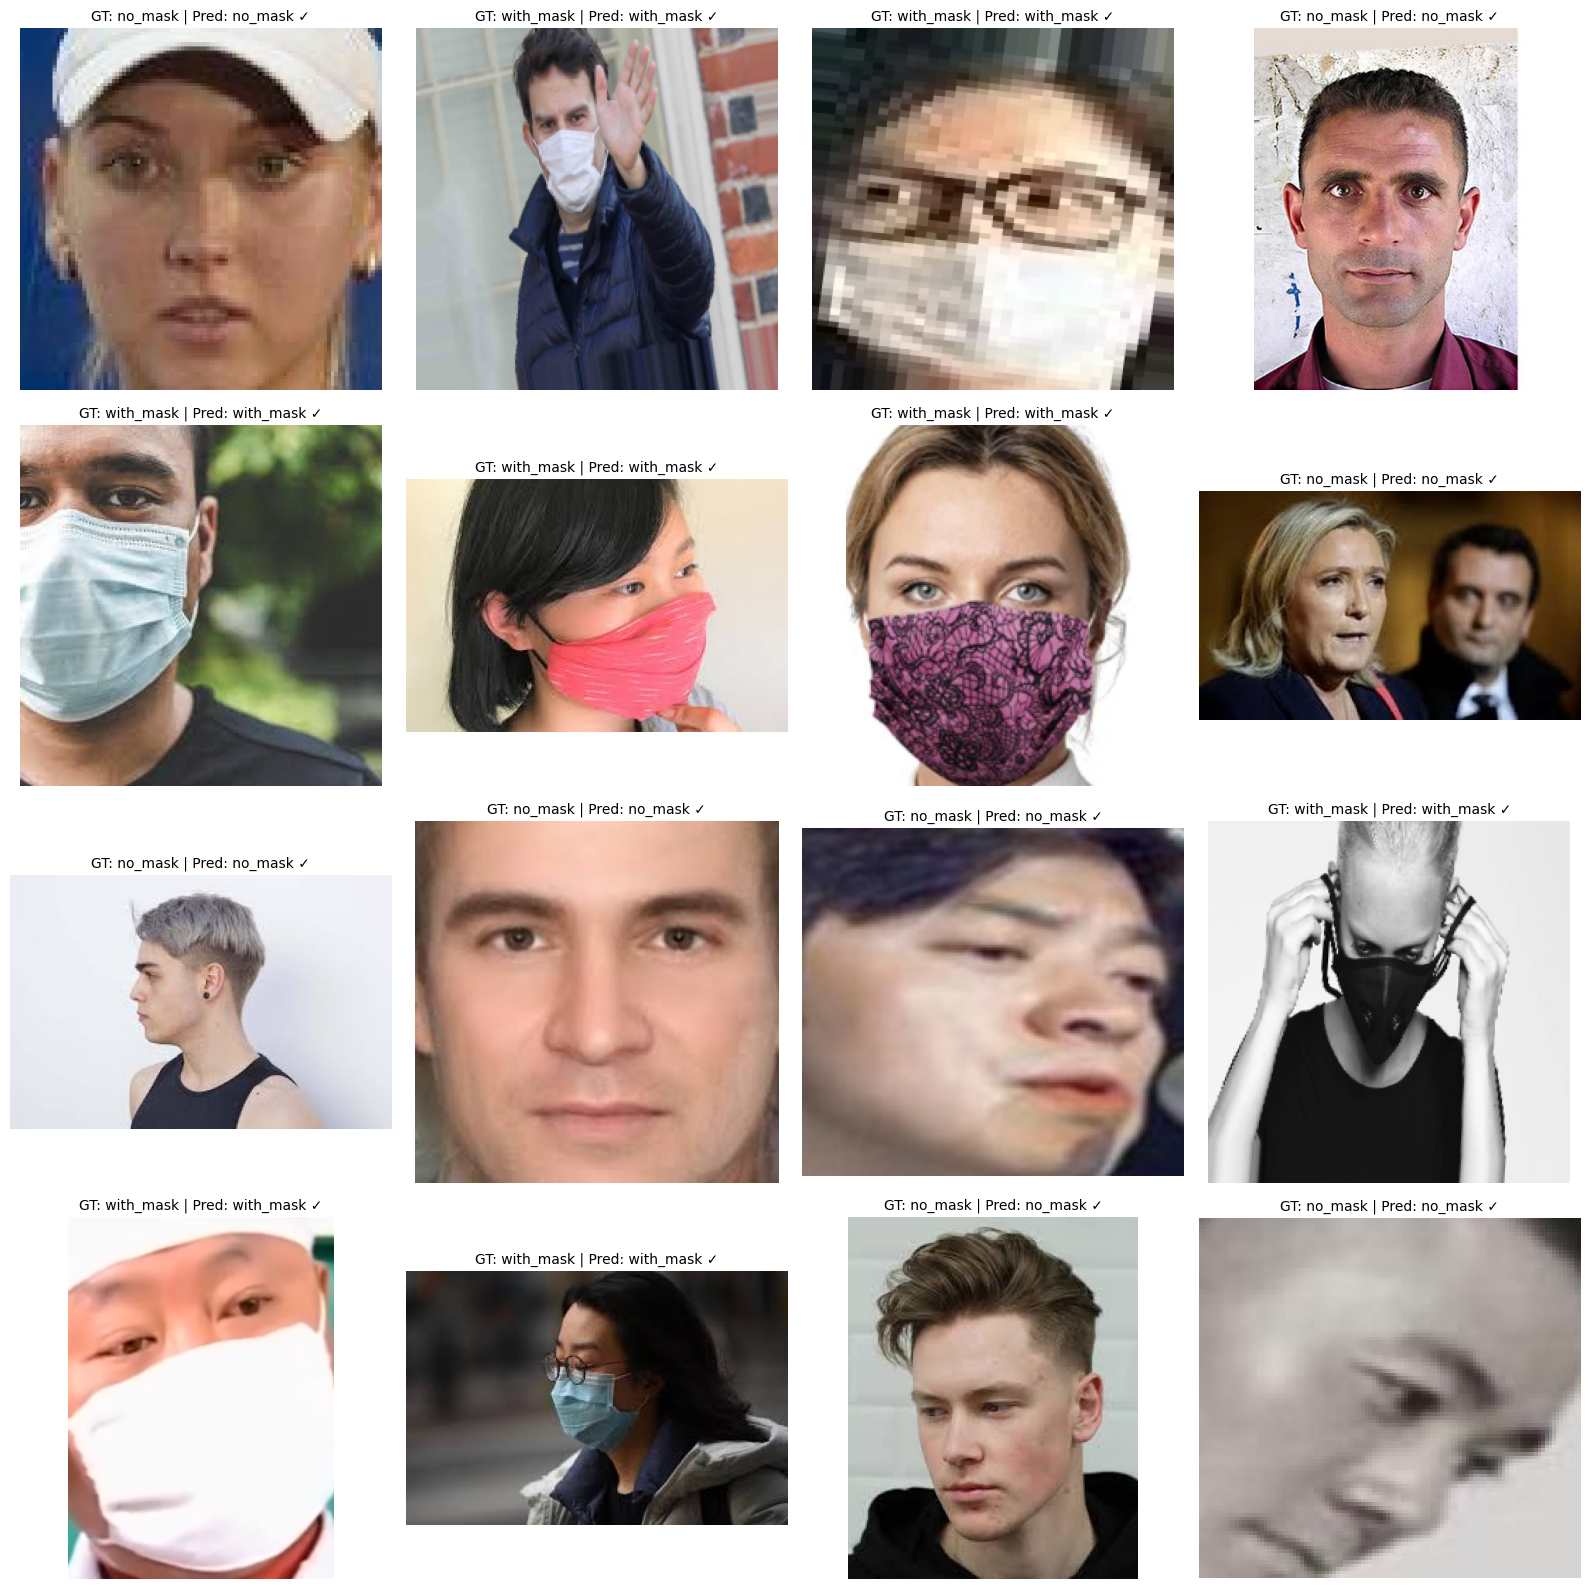

In [ ]:
# ---------- config ----------
TXT_PATH = "/Users/karimabdallah/Desktop/Mask-detection/data/splits/DS3_test.txt"
DELIM = "\t"          # change to " " if your split file is space-separated
LABEL_NAMES = {0: "no_mask", 1: "with_mask"}
SELECTION = "correct" # options: "correct", "tp", "tn"
MAX_SHOW = 16
SEED = 42
# ---------------------------

# 1) Load DS3_test image paths in the SAME order as X_test
test_paths, test_labels_from_txt = [], []
with open(TXT_PATH, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        p, lab = line.rsplit(DELIM, 1)
        test_paths.append(p)
        test_labels_from_txt.append(int(lab))
test_paths = np.array(test_paths)
test_labels_from_txt = np.array(test_labels_from_txt)

assert len(test_paths) == len(y_test), "Mismatch: DS3_test.txt lines vs y_test length"
# Optional sanity:
# print("Label order matches:", np.all(test_labels_from_txt == y_test))

# 2) Predictions (use your fitted pipeline)
y_pred = model.predict(X_test)  # or: best_model.predict(X_test)

# 3) Choose indices to visualize
if SELECTION == "correct":
    idx_pool = np.where(y_pred == y_test)[0]
elif SELECTION == "tp":
    idx_pool = np.where((y_test == 1) & (y_pred == 1))[0]
elif SELECTION == "tn":
    idx_pool = np.where((y_test == 0) & (y_pred == 0))[0]
else:
    raise ValueError("SELECTION must be 'correct', 'tp', or 'tn'.")

if len(idx_pool) == 0:
    raise ValueError(f"No samples found for selection: {SELECTION}")

rng = np.random.default_rng(SEED)
k = min(MAX_SHOW, len(idx_pool))
idxs = rng.choice(idx_pool, size=k, replace=False)

# 4) Plot grid
cols = 4
rows = int(np.ceil(k / cols))
plt.figure(figsize=(4*cols, 4*rows))

for i, idx in enumerate(idxs, start=1):
    img = Image.open(test_paths[idx]).convert("RGB")
    ax = plt.subplot(rows, cols, i)
    ax.imshow(img)
    gt = int(y_test[idx]); pr = int(y_pred[idx])
    ax.set_title(f"GT: {LABEL_NAMES[gt]} | Pred: {LABEL_NAMES[pr]} ✓", fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [ ]:

# === run_webcam entrypoint ===

import sys
from pathlib import Path
from typing import Tuple, Union

import cv2
import joblib
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from torchvision import models

ModelPath = Union[Path, str]
SplitsPath = Union[Path, str]


def build_transform() -> T.Compose:
    """Return the evaluation transform used during feature extraction."""
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    return T.Compose(
        [
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(mean, std),
        ]
    )


def load_feature_extractor(device: torch.device) -> torch.nn.Module:
    """Load a ResNet50 backbone without a classifier head."""
    resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    resnet.fc = torch.nn.Identity()
    resnet.eval()
    resnet.to(device)
    return resnet


def prepare_face(
    frame: np.ndarray, bbox: Tuple[int, int, int, int], transform: T.Compose
) -> torch.Tensor:
    """Crop, convert and transform a detected face ROI."""
    x, y, w, h = bbox
    face = frame[y : y + h, x : x + w]
    if face.size == 0:
        raise ValueError('Empty face crop encountered.')

    face_rgb = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(face_rgb)
    tensor = transform(pil_img).unsqueeze(0)
    return tensor


def annotate_frame(
    frame: np.ndarray, bbox: Tuple[int, int, int, int], label: str, confidence: float
) -> None:
    """Draw bounding box and prediction label on the frame in-place."""
    x, y, w, h = bbox
    color = (0, 200, 0) if label == 'Mask' else (0, 0, 255)
    cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
    text = f"{label} ({confidence:.2f})"
    cv2.putText(
        frame,
        text,
        (x, max(20, y - 10)),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.6,
        color,
        2,
        cv2.LINE_AA,
    )


def load_or_train_classifier(model_path: Path, splits_dir: Path) -> Pipeline:
    """Load classifier if present; otherwise train and persist it."""
    if model_path.exists():
        print(f"[info] Loading classifier: {model_path}")
        return joblib.load(model_path)

    expected = {
        'train': splits_dir / 'DS3_train.npz',
        'val': splits_dir / 'DS3_val.npz',
    }
    missing = [name for name, path in expected.items() if not path.exists()]
    if missing:
        hint = ', '.join(missing)
        raise FileNotFoundError(
            f"Missing required feature files in {splits_dir}: {hint}. "
            "Generate them by running feature extraction or provide a trained classifier."
        )

    def load_npz(path: Path) -> Tuple[np.ndarray, np.ndarray]:
        data = np.load(path, allow_pickle=False)
        return data['X'], data['y']

    X_train, y_train = load_npz(expected['train'])
    X_val, y_val = load_npz(expected['val'])
    X_pool = np.concatenate([X_train, X_val], axis=0)
    y_pool = np.concatenate([y_train, y_val], axis=0)

    print(f"[info] Training LinearSVC on pooled features ({X_pool.shape[0]} samples).")
    pipeline = Pipeline(
        [
            ('scaler', StandardScaler()),
            ('svm', LinearSVC(dual=False, C=1.0, class_weight='balanced', max_iter=10000)),
        ]
    )
    pipeline.fit(X_pool, y_pool)

    model_path.parent.mkdir(parents=True, exist_ok=True)
    joblib.dump(pipeline, model_path)
    print(f"[info] Saved classifier to {model_path}")
    return pipeline


def run_webcam(
    model_path: ModelPath,
    splits_dir: SplitsPath,
    camera_index: int = 0,
    use_gpu: bool = True,
) -> None:
    """Run real-time mask detection using the webcam feed."""
    model_path = Path(model_path)
    splits_dir = Path(splits_dir)

    clf = load_or_train_classifier(model_path, splits_dir)

    device = torch.device('cuda' if use_gpu and torch.cuda.is_available() else 'cpu')
    feature_extractor = load_feature_extractor(device)
    transform = build_transform()

    cascade_path = Path(cv2.data.haarcascades) / 'haarcascade_frontalface_default.xml'
    face_detector = cv2.CascadeClassifier(str(cascade_path))
    if face_detector.empty():
        raise RuntimeError(f'Failed to load Haar cascade from {cascade_path}')

    cap = cv2.VideoCapture(camera_index)
    if not cap.isOpened():
        raise RuntimeError(f'Could not open camera index {camera_index}')

    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                print('Failed to read frame from camera. Exiting.')
                break

            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_detector.detectMultiScale(
                gray,
                scaleFactor=1.1,
                minNeighbors=5,
                minSize=(80, 80),
            )

            for (x, y, w, h) in faces:
                try:
                    face_tensor = prepare_face(frame, (x, y, w, h), transform).to(device)
                    with torch.no_grad():
                        feat = feature_extractor(face_tensor).cpu().numpy()
                    pred = clf.predict(feat)[0]
                    decision = clf.decision_function(feat)
                    confidence = float(abs(decision[0])) if decision.ndim == 1 else float(max(decision[0]))
                    label = 'Mask' if int(pred) == 1 else 'No Mask'
                    annotate_frame(frame, (x, y, w, h), label, confidence)
                except Exception as err:  # keep the loop running
                    print(f"[warn] Skipping face: {err}", file=sys.stderr)
                    continue

            cv2.imshow('Mask Detector', frame)
            key = cv2.waitKey(1) & 0xFF
            if key in (27, ord('q')):
                break
    finally:
        cap.release()
        cv2.destroyAllWindows()
